In [2]:
!pip install torch_geometric > /dev/null 2>&1
!pip install zarr==2.13.0 > /dev/null 2>&1
!pip install numcodecs==0.13.1 > /dev/null 2>&1

In [9]:
!unzip /content/coo_optim_2_valid.zarr.zip -d data

Archive:  /content/coo_optim_2_valid.zarr.zip
   creating: data/coo_optim_2_valid.zarr/
  inflating: data/coo_optim_2_valid.zarr/.zattrs  
 extracting: data/coo_optim_2_valid.zarr/.zgroup  
   creating: data/coo_optim_2_valid.zarr/dense/
 extracting: data/coo_optim_2_valid.zarr/dense/.zgroup  
   creating: data/coo_optim_2_valid.zarr/dense/data/
  inflating: data/coo_optim_2_valid.zarr/dense/data/.zarray  
  inflating: data/coo_optim_2_valid.zarr/dense/data/0  
  inflating: data/coo_optim_2_valid.zarr/dense/data/1  
  inflating: data/coo_optim_2_valid.zarr/dense/data/10  
  inflating: data/coo_optim_2_valid.zarr/dense/data/11  
  inflating: data/coo_optim_2_valid.zarr/dense/data/12  
  inflating: data/coo_optim_2_valid.zarr/dense/data/13  
  inflating: data/coo_optim_2_valid.zarr/dense/data/2  
  inflating: data/coo_optim_2_valid.zarr/dense/data/3  
  inflating: data/coo_optim_2_valid.zarr/dense/data/4  
  inflating: data/coo_optim_2_valid.zarr/dense/data/5  
  inflating: data/coo_opti

In [7]:
!unzip /content/coo_optim_2_test.zarr.zip -d data

Archive:  /content/coo_optim_2_test.zarr.zip
   creating: data/coo_optim_2_test.zarr/
  inflating: data/coo_optim_2_test.zarr/.zattrs  
 extracting: data/coo_optim_2_test.zarr/.zgroup  
   creating: data/coo_optim_2_test.zarr/dense/
 extracting: data/coo_optim_2_test.zarr/dense/.zgroup  
   creating: data/coo_optim_2_test.zarr/dense/data/
  inflating: data/coo_optim_2_test.zarr/dense/data/.zarray  
  inflating: data/coo_optim_2_test.zarr/dense/data/0  
  inflating: data/coo_optim_2_test.zarr/dense/data/1  
  inflating: data/coo_optim_2_test.zarr/dense/data/10  
  inflating: data/coo_optim_2_test.zarr/dense/data/11  
  inflating: data/coo_optim_2_test.zarr/dense/data/12  
  inflating: data/coo_optim_2_test.zarr/dense/data/13  
  inflating: data/coo_optim_2_test.zarr/dense/data/14  
  inflating: data/coo_optim_2_test.zarr/dense/data/2  
  inflating: data/coo_optim_2_test.zarr/dense/data/3  
  inflating: data/coo_optim_2_test.zarr/dense/data/4  
  inflating: data/coo_optim_2_test.zarr/den

In [8]:
!unzip /content/coo_optim_2.zarr.zip -d data

Archive:  /content/coo_optim_2.zarr.zip
   creating: data/coo_optim_2.zarr/
  inflating: data/coo_optim_2.zarr/.zattrs  
 extracting: data/coo_optim_2.zarr/.zgroup  
   creating: data/coo_optim_2.zarr/dense/
 extracting: data/coo_optim_2.zarr/dense/.zgroup  
   creating: data/coo_optim_2.zarr/dense/data/
  inflating: data/coo_optim_2.zarr/dense/data/.zarray  
  inflating: data/coo_optim_2.zarr/dense/data/0  
  inflating: data/coo_optim_2.zarr/dense/data/1  
  inflating: data/coo_optim_2.zarr/dense/data/10  
  inflating: data/coo_optim_2.zarr/dense/data/11  
  inflating: data/coo_optim_2.zarr/dense/data/12  
  inflating: data/coo_optim_2.zarr/dense/data/13  
  inflating: data/coo_optim_2.zarr/dense/data/14  
  inflating: data/coo_optim_2.zarr/dense/data/2  
  inflating: data/coo_optim_2.zarr/dense/data/3  
  inflating: data/coo_optim_2.zarr/dense/data/4  
  inflating: data/coo_optim_2.zarr/dense/data/5  
  inflating: data/coo_optim_2.zarr/dense/data/6  
  inflating: data/coo_optim_2.zar

cuda
8085
8085


Обучение:   0%|          | 0/30 [00:00<?, ?it/s]

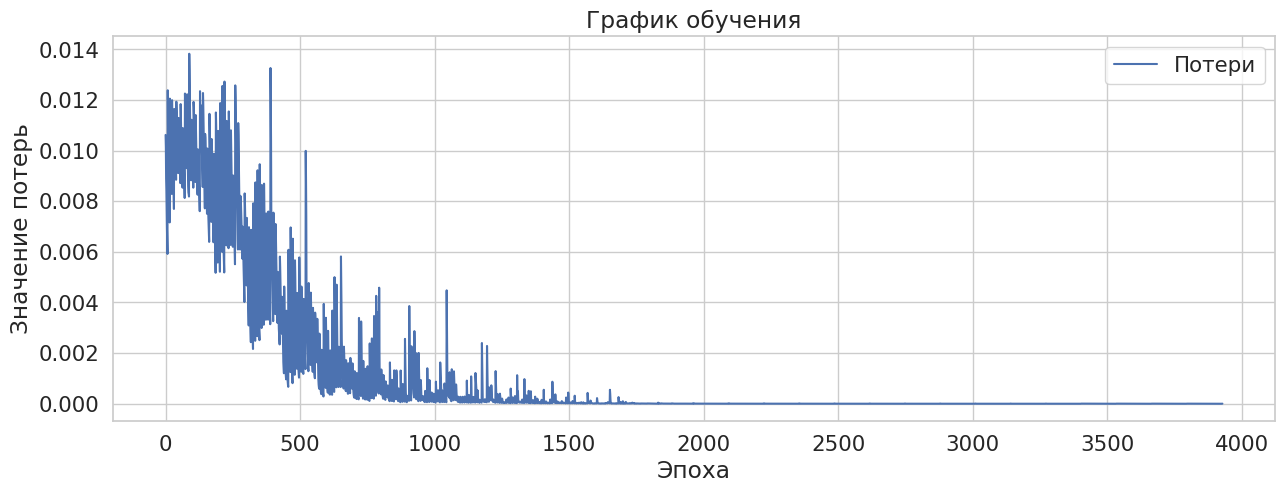

In [10]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns

import torch.multiprocessing

torch.multiprocessing.set_sharing_strategy("file_system")

from dataset import SEEDIVDataset, AsyncBatchLoader

# Установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

sns.set(font_scale=1.4, style="whitegrid")
figure_format = "retina"


class DCGRU(nn.Module):
    def __init__(self, input_dim, hiden_dim, K, normalization="sym"):
        super().__init__()
        self.input_dim = input_dim
        self.hiden_dim = hiden_dim
        self.K = K

        self.reset_conv = gnn.ChebConv(
            input_dim + hiden_dim, hiden_dim, K, normalization
        ).to(device)
        self.update_conv = gnn.ChebConv(
            input_dim + hiden_dim, hiden_dim, K, normalization
        ).to(device)
        self.mem_conv = gnn.ChebConv(
            input_dim + hiden_dim, hiden_dim, K, normalization
        ).to(device)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, edge_idx, edge_attr):
        hiden = torch.zeros(x[0].shape[0], self.hiden_dim).to(device)

        for x_item, edge_item, attr_item in zip(x, edge_idx, edge_attr):

            x_item = x_item.to(device)
            edge_item = edge_item.to(device)
            attr_item = attr_item.to(device)

            combined = torch.cat((x_item, hiden), dim=1)

            # Reset gate
            r = self.sigmoid(self.reset_conv(combined, edge_item, attr_item))

            # Update gate
            u = self.sigmoid(self.update_conv(combined, edge_item, attr_item))

            # Memory candidate
            c = self.tanh(
                self.mem_conv(
                    torch.cat((x_item, r * hiden), dim=1), edge_item, attr_item
                )
            )

            hiden = u * hiden + (1 - u) * c

        return hiden


class EmoClassifaer(nn.Module):
    def __init__(
        self, num_classes, num_nodes, input_dim, hiden_dim, K, normalization="sym"
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.hiden_dim = hiden_dim
        self.dcgru = DCGRU(input_dim, hiden_dim, K, normalization).to(device)
        self.net = nn.Sequential(
            nn.Linear(num_nodes, 64).to(device),
            nn.ReLU(),
            nn.Linear(64, num_classes).to(device),
        )

    def forward(self, x, edge_idx, edge_attr):
        hiden = self.dcgru(x, edge_idx, edge_attr)
        batch = torch.stack(torch.split(hiden, self.num_nodes, dim=0), dim=0)
        input = torch.mean(batch, dim=2)
        return self.net(input)


if __name__ == "__main__":
    # Инициализация датасета и загрузчика
    dataset = SEEDIVDataset("data/coo_optim_2.zarr", group_shape=(6, 62, 5))
    dataset = [dataset[i] for i in range(len(dataset))]

    print(len(dataset))
    loader = DataLoader(
        dataset,
        batch_size=62,
        shuffle=True,
        num_workers=0
    )

    loader_size = len(loader)

    loader = AsyncBatchLoader(loader)
    processes =  loader.start_workers(num_workers=8)

    model = EmoClassifaer(4, 62, 5, 8, 5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(device)

    losses = []

    print(len(dataset))

    batches = [loader.get_batch() for _ in np.arange(loader_size)]

    for _ in tqdm(np.arange(30), desc="Обучение"):

        for batch in batches:


            x_batch = [data.x.to(device) for data in batch[0]]
            idx_batch = [data.edge_index.to(device) for data in batch[0]]
            attr_batch = [data.edge_attr.to(device) for data in batch[0]]
            labels = batch[1].to(torch.long).to(device)

            optimizer.zero_grad()

            outputs = model(x_batch, idx_batch, attr_batch)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            losses.append(loss.item() / loader_size)

    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        "emo_classifier.pth",
    )



    # Визуализация потерь
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(len(losses)), losses, label="Потери")
    plt.xlabel("Бачи")
    plt.ylabel("Значение потерь")
    plt.title("График обучения")
    plt.legend()
    plt.savefig("training_plot2.png", dpi=300, bbox_inches="tight")
    plt.show()


In [45]:
np.save("losses3.npy", losses)

In [11]:
# Инициализация датасета и загрузчика
model.eval()
test_dataset = SEEDIVDataset("data/coo_optim_2_test.zarr", group_shape=(6, 62, 5))
print(len(test_dataset))
test_loader = DataLoader(
    test_dataset,
    batch_size=62,
    shuffle=True,
    num_workers=0
)

test_loader_size = len(loader)

test_loader = AsyncBatchLoader(test_loader)
processes =  test_loader.start_workers(num_workers=8)

criterion = nn.CrossEntropyLoss().to(device)
test_losses = []
test_batches = [test_loader.get_batch() for _ in np.arange(test_loader_size)]

num_diff = 0

for batch in tqdm(test_batches, desc="test"):

        x_batch = [data.x.to(device) for data in batch[0]]
        idx_batch = [data.edge_index.to(device) for data in batch[0]]
        attr_batch = [data.edge_attr.to(device) for data in batch[0]]
        labels = batch[1].to(torch.long).to(device)


        outputs = model(x_batch, idx_batch, attr_batch)
        torch.argmax(outputs, dim=2)

        num_diff += torch.sum(outputs != labels).item()


print(num_diff / len(test_dataset))

7905


test:   0%|          | 0/131 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (4) must match the size of tensor b (62) at non-singleton dimension 1

In [33]:
from torch.utils.data import Dataset

class DDD(Dataset):
    def __init__(self, data):
        super().__init__()

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = SEEDIVDataset("data/coo_optim_2.zarr", group_shape=(6, 62, 5))
dataset = [dataset[i] for i in range(len(dataset))]

dataset = DDD(dataset)

In [34]:
loader = DataLoader(
    dataset,
    batch_size=62,
    shuffle=True,
    num_workers=0
)

In [42]:
from torch.nn.functional import softmax

num_diff = 0

for batch in tqdm(test_batches, desc="test"):

        x_batch = [data.x.to(device) for data in batch[0]]
        idx_batch = [data.edge_index.to(device) for data in batch[0]]
        attr_batch = [data.edge_attr.to(device) for data in batch[0]]
        labels = batch[1].to(torch.long).to(device)


        outputs = model(x_batch, idx_batch, attr_batch)
        outputs = softmax(outputs, dim=1)
        outputs = torch.argmax(outputs, dim=1)

        num_diff += torch.sum(outputs != labels).item()


print(1 - num_diff / len(test_dataset))

test:   0%|          | 0/131 [00:00<?, ?it/s]

0.2471853257432005


Обучение:   0%|          | 0/80 [00:00<?, ?it/s]

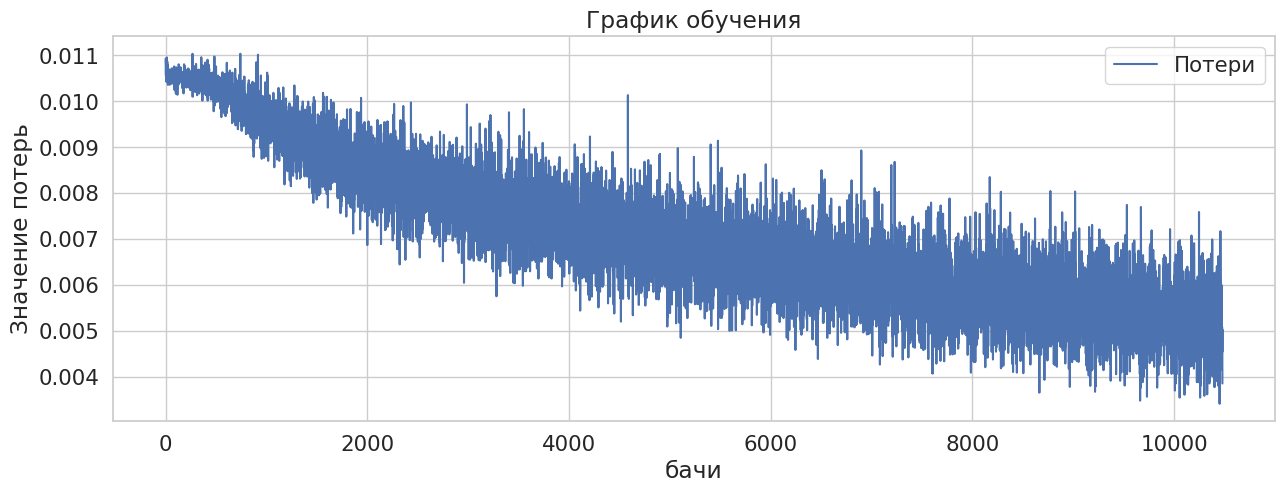

In [40]:
from torch.optim.lr_scheduler import StepLR



class EmoClassifaer(nn.Module):
    def __init__(
        self, num_classes, num_nodes, input_dim, hiden_dim, K, normalization="sym"
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.hiden_dim = hiden_dim
        self.dcgru = DCGRU(input_dim, hiden_dim, K, normalization).to(device)
        self.net = nn.Sequential(
            nn.Linear(num_nodes, 64).to(device),
            nn.ReLU(),
            nn.Linear(64, num_classes).to(device),
        )

    def forward(self, x, edge_idx, edge_attr):
        hiden = self.dcgru(x, edge_idx, edge_attr)
        batch = torch.stack(torch.split(hiden, self.num_nodes, dim=0), dim=0)
        input = torch.mean(batch, dim=2)
        return self.net(input)

if __name__ == "__main__":

    model = EmoClassifaer(4, 62, 5, 8, 5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

    losses = []



    for _ in tqdm(np.arange(80), desc="Обучение"):

        for batch in loader:


            x_batch = [data.x.to(device) for data in batch[0]]
            idx_batch = [data.edge_index.to(device) for data in batch[0]]
            attr_batch = [data.edge_attr.to(device) for data in batch[0]]
            labels = batch[1].to(torch.long).to(device)

            optimizer.zero_grad()

            outputs = model(x_batch, idx_batch, attr_batch)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            losses.append(loss.item() / loader_size)

        scheduler.step()


    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        "emo_classifier2.pth",
    )



    # Визуализация потерь
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(len(losses)), losses, label="Потери")
    plt.xlabel("бачи")
    plt.ylabel("Значение потерь")
    plt.title("График обучения")
    plt.legend()
    plt.savefig("training_plot2.png", dpi=300, bbox_inches="tight")
    plt.show()


In [43]:
from torch.nn.functional import softmax

num_diff = 0

for batch in tqdm(test_batches, desc="test"):

        x_batch = [data.x.to(device) for data in batch[0]]
        idx_batch = [data.edge_index.to(device) for data in batch[0]]
        attr_batch = [data.edge_attr.to(device) for data in batch[0]]
        labels = batch[1].to(torch.long).to(device)


        outputs = model(x_batch, idx_batch, attr_batch)
        outputs = softmax(outputs, dim=1)
        outputs = torch.argmax(outputs, dim=1)

        num_diff += torch.sum(outputs != labels).item()


print(1 - num_diff / len(test_dataset))

test:   0%|          | 0/131 [00:00<?, ?it/s]

0.2471853257432005


In [32]:
from torch.utils.data import Dataset

class DDD(Dataset):
    def __init__(self, data):
        super().__init__()

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]